# 🚬 Smoking Intensity Prediction Using Neural Networks

Welcome to this project where I use **neural networks** to predict smoking intensity levels based on survey data. We will:
- Experiment with **different architectures**.
- Compare performance with **all features** vs. **top features**.
- Plot and analyze results to gain insights into model behavior.

### **Target Classes**
The model predicts the following smoking intensity categories:
- **0**: 10 or less cigarettes/day
- **1**: 11 to 20 cigarettes/day
- **2**: 21 to 30 cigarettes/day
- **3**: 31 or more cigarettes/day

Let's get started! 🚀


## Step 1: Load and Clean the Data
In this step, we will:
1. Load the dataset from a CSV file.
2. Clean the data by:
   - Removing unnamed or duplicate columns.
   - Handling categorical and target columns appropriately.


In [1]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# Authenticate
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open spreadsheet (using your URL)
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1IWa_g1cV54JcTRdXXUCFElOAvQcfy0o5wDI34IpdnYs/edit?usp=sharing'
worksheet = gc.open_by_url(spreadsheet_url).sheet1
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Now you can view your data
print(df.shape)  # See the dimensions of your dataframe
df.head()  # View first few rows

(212, 48)


,,Sector,Last page,Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?,"I see myself as someone who is extraverted, enthusiastic:","I see myself as someone who is critical, quarrelsome:","I see myself as someone who is dependable, self-disciplined:","I see myself as someone who is anxious, easily upset:",I see myself as someone who is open to new experiences:,"I see myself as someone who is reserved, quiet:",...,What type of income or financial support does your household receive?,What type of income or financial support does your household receive? [Comment],"If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).",How would you describe your current income sufficiency?,"Including yourself, how many people currently live in your household?",To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?,How often do you exercise?,"On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?",How often do you feel stressed?,Employment Status
0,5,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Agree moderately,Agree strongly,Agree a little,...,Fully in Lebanese Lira,,More than 20 million L.L,High: completely covers necessities with a few...,4,Very,Never,Between 2 and 3 hours,Frequently,Employed
1,11,Private,5,Yes,Agree moderately,Agree moderately,Agree moderately,Agree a little,Agree strongly,Disagree strongly,...,Fully in US Dollars,,More than 20 million L.L,High: completely covers necessities with a few...,4,Slightly,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Unemployed
2,14,Private,5,Yes,Disagree moderately,Neither agree nor disagree,Agree a little,Agree moderately,Disagree a little,Agree moderately,...,Fully in Lebanese Lira,,I don't know,High: completely covers necessities with a few...,4,Moderately,Every day or at least 5 times every week,More than 4 hours,Constantly,Employed
3,15,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Disagree strongly,Agree strongly,Disagree moderately,...,Mixed,,I don't know,Medium: covers all basic needs,5,Moderately,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Employed
4,16,Private,5,Yes,Agree a little,Agree a little,Agree strongly,Disagree moderately,Agree moderately,Agree strongly,...,"Other, please specify",,I prefer not to say,Medium: covers all basic needs,6,Slightly,Every day or at least 5 times every week,Less than 1 hour,Never,Employed


In [2]:
def clean_data(df):
    unnamed_cols = [col for col in df.columns if "Unnamed" in col]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)
    df = df.loc[:, ~df.columns.duplicated()]
    return df

df = clean_data(df)

print("First 5 rows of cleaned data:")
print(df.head())

First 5 rows of cleaned data:
        Sector  Last page  \
0   5  Private          5   
1  11  Private          5   
2  14  Private          5   
3  15  Private          5   
4  16  Private          5   

  Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?  \
0                                                Yes                                                               
1                                                Yes                                                               
2                                                Yes                                                               
3                                                Yes                                                               
4                                                Yes                                                               

  I see myself as someone who is extraverted, enthusiastic:  \
0                                  

## Step 2: Preprocess the Data
We preprocess the dataset by:
1. Encoding binary and categorical columns.
2. Mapping the target variable to numerical values.
3. Scaling numerical features using z-score normalization.
4. Selecting top features based on correlation.


In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_data_nn(df):
    # Encode binary columns
    binary_columns = [col for col in df.columns if set(df[col].dropna().unique()) == {"Yes", "No"}]
    for col in binary_columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

    # Map personality questions
    response_map = {
        "Disagree strongly": 0, "Disagree moderately": 1, "Disagree a little": 2,
        "Neither agree nor disagree": 3, "Agree a little": 4,
        "Agree moderately": 5, "Agree strongly": 6
    }
    personality_columns = [col for col in df.columns if "I see myself as" in col]
    for col in personality_columns:
        df[col] = df[col].map(response_map)

    # Map target variable
    target_map = {
        "10 or less cigarettes/day": 0,
        "11 to 20 cigarettes": 1,
        "21 to 30 cigarettes": 2,
        "31 cigarettes/day or more": 3
    }
    df["smoking_intensity"] = df["How many cigarettes do you smoke each day?"].map(target_map)
    df = df.drop(columns=["How many cigarettes do you smoke each day?"], errors="ignore")

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, drop_first=True)
    X = df_encoded.drop(columns=['smoking_intensity'], errors='ignore')
    y = df_encoded['smoking_intensity']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=X.columns), y

# Preprocess data
X, y = preprocess_data_nn(df)
print("Processed feature data (first 5 rows):")
print(X.head())


Processed feature data (first 5 rows):
             Last page  \
0 -2.046917        0.0   
1 -2.008033        0.0   
2 -1.988591        0.0   
3 -1.982110        0.0   
4 -1.975630        0.0   

   I see myself as someone who is extraverted, enthusiastic:  \
0                                           1.180832           
1                                           0.577612           
2                                          -1.835270           
3                                           1.180832           
4                                          -0.025608           

   I see myself as someone who is critical, quarrelsome:  \
0                                          -1.635285       
1                                           1.168061       
2                                          -0.233612       
3                                          -1.635285       
4                                           0.467224       

   I see myself as someone who is dependable, self-discipl

## Step 3: Select Top Features
We select the top features based on their correlation with the target variable. This helps reduce dimensionality and focus on the most relevant predictors.


In [4]:
# Select top features
def select_top_features(df, y, num_features=10):
    df["target"] = y
    correlations = df.corr()["target"].drop("target").abs().sort_values(ascending=False)
    top_features = correlations.head(num_features).index.tolist()
    return top_features

# Choose top 10 features
top_features = select_top_features(X, y, num_features=10)
X = X[top_features]
print(f"Selected top 10 features: {top_features}")


Selected top 10 features: ['Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?', 'How soon after you wake up do you smoke your first cigarette?_After 60 minutes', 'What is your favorite or preferred cigarette brand(s) if you were able to access it?_marlboro', 'Do you smoke more frequently during the first hours after waking up than during the rest of the day?\xa0', 'Which cigarette would you mostly hate to give up?_The first one in the morning', '', 'If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange)._More than 20 million L.L', 'Do you smoke if you are so ill that you are in bed most of the day?', 'What cigarette brand(s) are you currently using?_marlboro', 'Of the five closest friends or acquaintances that you spend time with on a regular basis, how many of them are smokers?']


## Step 4: Split the Dataset
We split the dataset into training and testing sets:
- **Training Set**: 85% of the data.
- **Testing Set**: 15% of the data.


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Convert target to categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
print("Train and test data prepared.")


Train and test data prepared.


## Step 5: Train the Neural Network
We build and train a neural network with the following architecture:
- **Input Layer**: Based on the number of selected features.
- **Hidden Layers**: Multiple configurations with `ReLU` activation.
- **Output Layer**: A softmax layer for multi-class classification.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build neural network
def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')  # 4 output classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model
print("Training Neural Network...")
model = build_nn(input_dim=X_train.shape[1])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Training Neural Network...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.2499 - loss: 1.5873 - val_accuracy: 0.1944 - val_loss: 1.4160
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1975 - loss: 1.5299 - val_accuracy: 0.3611 - val_loss: 1.3254
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3563 - loss: 1.3900 - val_accuracy: 0.5278 - val_loss: 1.2527
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3990 - loss: 1.3435 - val_accuracy: 0.5833 - val_loss: 1.1916
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4128 - loss: 1.2764 - val_accuracy: 0.6389 - val_loss: 1.1403
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4478 - loss: 1.2494 - val_accuracy: 0.6667 - val_loss: 1.0951
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4152 - loss: 1.2807 - val_accuracy: 0.6389 - val_loss: 1.0576
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5247 - loss: 1.1797 - val_accuracy: 0.6944 - val_loss: 1.0224

## Step 6: Evaluate and Visualize
We evaluate the model on the test set and visualize:
- **Classification Report**
- **Confusion Matrix**
- **Validation Loss vs. Epochs**


Test Loss: 0.8195, Test Accuracy: 0.6250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.71      0.45      0.56        11
           2       0.33      0.50      0.40         4
           3       0.67      0.50      0.57         4

    accuracy                           0.62        32
   macro avg       0.60      0.58      0.57        32
weighted avg       0.65      0.62      0.62        32



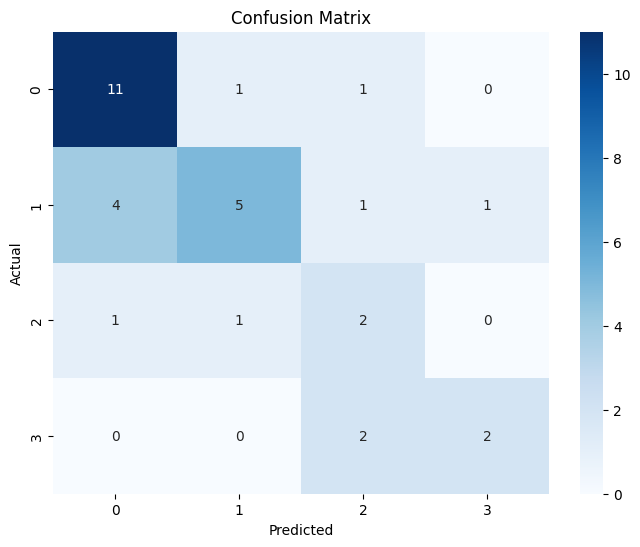

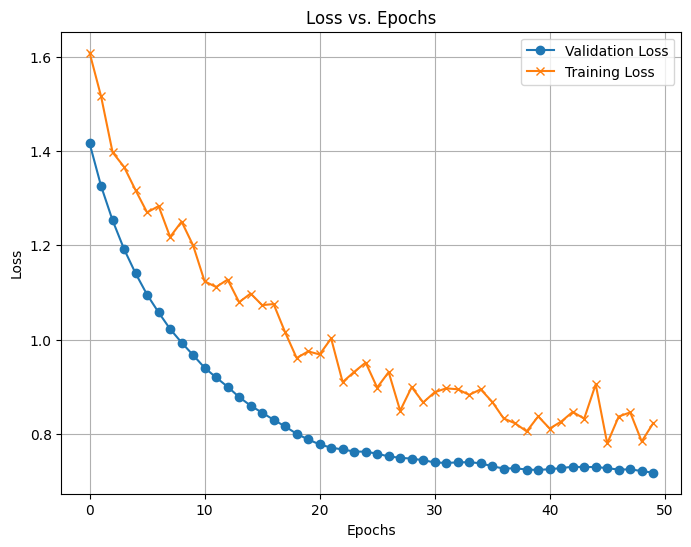

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict and generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss', marker='o')
plt.plot(history.epoch, history.history['loss'], label='Training Loss', marker='x')
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Step 7: Hyperparameter Tuning and Architecture Experimentation
We will systematically explore different configurations of:
1. **Number of Layers and Neurons**: Testing deeper or simpler architectures.
2. **Dropout Rates**: Balancing overfitting and model complexity.
3. **Learning Rate**: Adjusting the optimizer to improve convergence.
4. **Batch Size and Epochs**: Experimenting with different batch sizes and training durations.

This process will use a loop to try various combinations and identify the best performing configuration.


In [10]:
import tensorflow as tf

# Define hyperparameter options
architectures = [
    [(128, 0.3), (64, 0.3)],  # 2 layers: 128 neurons, then 64 neurons
    [(256, 0.4), (128, 0.3), (64, 0.2)],  # 3 layers: deeper architecture
    [(64, 0.2), (32, 0.2)],  # Simpler architecture
]

learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [16, 32, 64]
epochs = [50]  # Keeping epochs constant initially

# Function to dynamically build models
def build_custom_nn(input_dim, architecture, learning_rate):
    model = Sequential()
    model.add(Dense(architecture[0][0], activation='relu', input_dim=input_dim))
    model.add(Dropout(architecture[0][1]))

    for neurons, dropout_rate in architecture[1:]:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(4, activation='softmax'))  # Output layer for 4 classes
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform grid search over hyperparameters
results = []
for arch_id, arch in enumerate(architectures):
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nTraining Architecture {arch_id + 1} | LR: {lr} | Batch Size: {batch_size}")

            model = build_custom_nn(input_dim=X_train.shape[1], architecture=arch, learning_rate=lr)
            history = model.fit(X_train, y_train, epochs=epochs[0], batch_size=batch_size, validation_split=0.2, verbose=0)

            # Evaluate on test data
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

            results.append({
                "architecture": arch,
                "learning_rate": lr,
                "batch_size": batch_size,
                "loss": loss,
                "accuracy": accuracy,
                "history": history
            })



Training Architecture 1 | LR: 0.001 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7537, Test Accuracy: 0.6562

Training Architecture 1 | LR: 0.001 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7437, Test Accuracy: 0.6250

Training Architecture 1 | LR: 0.001 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7404, Test Accuracy: 0.6562

Training Architecture 1 | LR: 0.005 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.5129, Test Accuracy: 0.5625

Training Architecture 1 | LR: 0.005 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.2339, Test Accuracy: 0.6250

Training Architecture 1 | LR: 0.005 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.9490, Test Accuracy: 0.6250

Training Architecture 1 | LR: 0.01 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.5514, Test Accuracy: 0.5625

Training Architecture 1 | LR: 0.01 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.4824, Test Accuracy: 0.5938

Training Architecture 1 | LR: 0.01 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.3927, Test Accuracy: 0.5000

Training Architecture 2 | LR: 0.001 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.8564, Test Accuracy: 0.6250

Training Architecture 2 | LR: 0.001 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7713, Test Accuracy: 0.6562

Training Architecture 2 | LR: 0.001 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7248, Test Accuracy: 0.7188

Training Architecture 2 | LR: 0.005 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.6168, Test Accuracy: 0.5625

Training Architecture 2 | LR: 0.005 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.4147, Test Accuracy: 0.5938

Training Architecture 2 | LR: 0.005 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.0307, Test Accuracy: 0.6250

Training Architecture 2 | LR: 0.01 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.4069, Test Accuracy: 0.5312

Training Architecture 2 | LR: 0.01 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 2.1397, Test Accuracy: 0.4375

Training Architecture 2 | LR: 0.01 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.2831, Test Accuracy: 0.5625

Training Architecture 3 | LR: 0.001 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7498, Test Accuracy: 0.6562

Training Architecture 3 | LR: 0.001 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.7125, Test Accuracy: 0.6562

Training Architecture 3 | LR: 0.001 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.8457, Test Accuracy: 0.6562

Training Architecture 3 | LR: 0.005 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.4288, Test Accuracy: 0.5625

Training Architecture 3 | LR: 0.005 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.1411, Test Accuracy: 0.5625

Training Architecture 3 | LR: 0.005 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.8017, Test Accuracy: 0.6562

Training Architecture 3 | LR: 0.01 | Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.2726, Test Accuracy: 0.6562

Training Architecture 3 | LR: 0.01 | Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.2608, Test Accuracy: 0.5000

Training Architecture 3 | LR: 0.01 | Batch Size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 1.0159, Test Accuracy: 0.6562


## Step 8: Analyze Results
We will analyze the results from our hyperparameter search and identify the best-performing configuration. Additionally, we will plot validation loss and accuracy for deeper insights.



Best Configuration:
Architecture: [(256, 0.4), (128, 0.3), (64, 0.2)]
Learning Rate: 0.001
Batch Size: 64
Accuracy: 0.7188


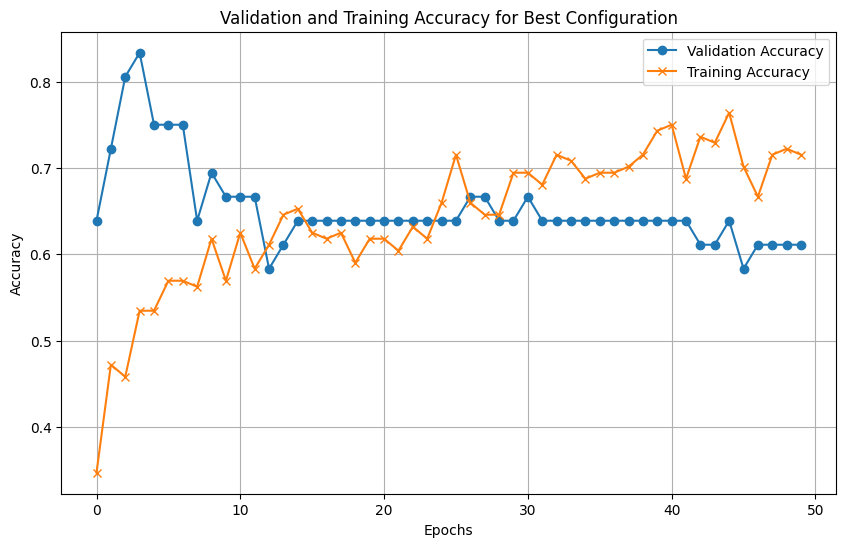

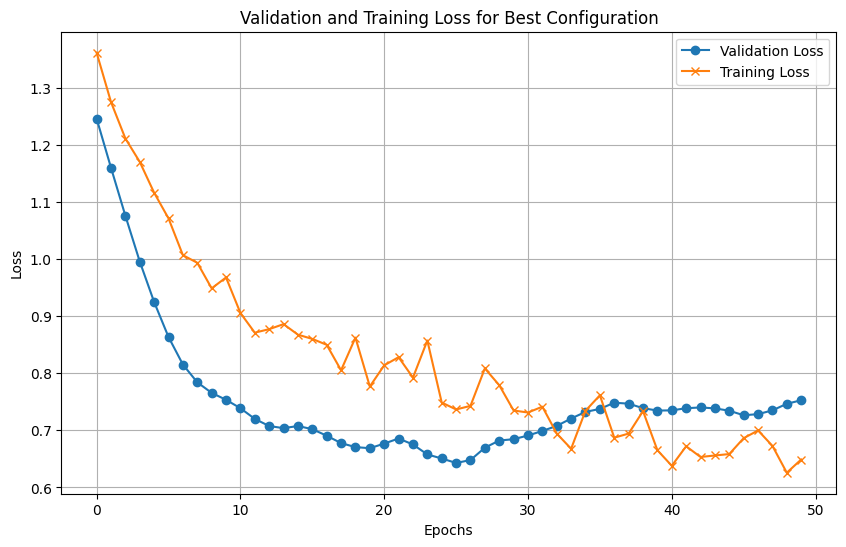

In [11]:
# Identify the best configuration
best_result = max(results, key=lambda x: x['accuracy'])
print("\nBest Configuration:")
print(f"Architecture: {best_result['architecture']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")

# Plot validation accuracy for top-performing configuration
plt.figure(figsize=(10, 6))
plt.plot(best_result['history'].epoch, best_result['history'].history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(best_result['history'].epoch, best_result['history'].history['accuracy'], label='Training Accuracy', marker='x')
plt.title("Validation and Training Accuracy for Best Configuration")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 6))
plt.plot(best_result['history'].epoch, best_result['history'].history['val_loss'], label='Validation Loss', marker='o')
plt.plot(best_result['history'].epoch, best_result['history'].history['loss'], label='Training Loss', marker='x')
plt.title("Validation and Training Loss for Best Configuration")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


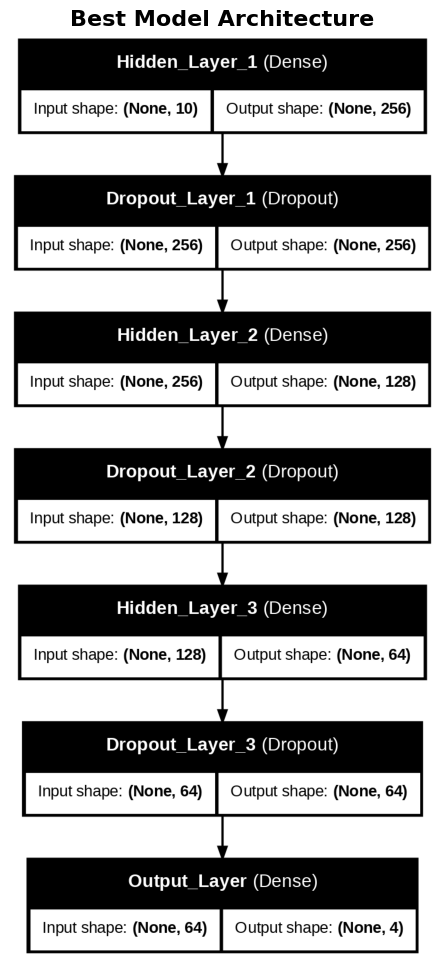

In [17]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Build the best model
def build_best_model(input_dim):
    """
    Builds the best model identified during hyperparameter tuning.
    Architecture:
    - Layer 1: Dense(256) with Dropout(0.4)
    - Layer 2: Dense(128) with Dropout(0.3)
    - Layer 3: Dense(64) with Dropout(0.2)
    - Output: Softmax (4 classes)
    """
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim, name="Hidden_Layer_1"),
        Dropout(0.4, name="Dropout_Layer_1"),
        Dense(128, activation='relu', name="Hidden_Layer_2"),
        Dropout(0.3, name="Dropout_Layer_2"),
        Dense(64, activation='relu', name="Hidden_Layer_3"),
        Dropout(0.2, name="Dropout_Layer_3"),
        Dense(4, activation='softmax', name="Output_Layer")  # 4 output classes
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
best_model = build_best_model(input_dim=X_train.shape[1])

# Plot and save the model architecture
plot_file = "best_model_architecture_pretty.png"
plot_model(best_model, to_file=plot_file, show_shapes=True, show_layer_names=True, dpi=150)

# Display the architecture
plt.figure(figsize=(12, 12))
img = plt.imread(plot_file)
plt.imshow(img)
plt.axis('off')
plt.title("Best Model Architecture", fontsize=16, fontweight="bold")
plt.show()


## Step: Experimenting with the Number of Epochs

Previously, we trained our model with **50 epochs**, achieving a test accuracy of ~62%. In this step, we will systematically vary the number of epochs to observe how it impacts the model's performance.

### Goals:
1. Identify the **optimal number of epochs** where the model performs best on the validation set.
2. Avoid **underfitting** (too few epochs) and **overfitting** (too many epochs).
3. Visualize how training and validation loss/accuracy change across epochs for different settings.

We will test the model with **25**, **50**, **75**, and **100 epochs** and analyze the results.


In [26]:
# Epoch values to experiment with
epoch_values = [5, 10, 15, 25, 50]

# Store results
epoch_results = []

# Train the model with different epochs and track optimal epochs
for num_epochs in epoch_values:
    print(f"\n--- Training Model with {num_epochs} Epochs ---")

    # Build the best model
    model = build_best_model(input_dim=X_train.shape[1])

    # Train the model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate on test data
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Save the results
    epoch_results.append({
        "epochs": num_epochs,
        "loss": loss,
        "accuracy": accuracy,
        "val_loss_history": history.history['val_loss'],
        "val_accuracy_history": history.history['val_accuracy']
    })

    # Print final validation metrics
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Determine the optimal number of epochs based on the lowest validation loss
optimal_epochs = None
best_val_loss = float('inf')
for result in epoch_results:
    min_loss_epoch = result["val_loss_history"].index(min(result["val_loss_history"])) + 1  # Epoch index starts from 0
    if result["val_loss_history"][min_loss_epoch - 1] < best_val_loss:
        best_val_loss = result["val_loss_history"][min_loss_epoch - 1]
        optimal_epochs = min_loss_epoch

print(f"\n--- Optimal Number of Epochs Based on Validation Loss: {optimal_epochs} ---")



--- Training Model with 5 Epochs ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.2413 - loss: 1.3834 - val_accuracy: 0.5278 - val_loss: 1.2653
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4175 - loss: 1.2698 - val_accuracy: 0.6667 - val_loss: 1.1395
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4761 - loss: 1.2089 - val_accuracy: 0.6944 - val_loss: 1.0312
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5451 - loss: 1.1332 - val_accuracy: 0.6944 - val_loss: 0.9282
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5328 - loss: 1.0444 - val_accuracy: 0.7222 - val_loss: 0.8416
Test Loss: 0.9460
Test Accuracy: 0.5625
Final Validation Loss: 0.8416
Final Validation Accuracy: 0.7222

--- Training Model with 10 Epochs ---
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3222 - loss: 1.3966 - val_accuracy: 0.7222 - val_loss: 1.2083
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4330 - loss: 1.2742 - val_accuracy: 0.6389 - val_loss: 1.0810
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4865 - loss: 1.1807 - val_accuracy: 0.7222 - val_loss: 0.9615
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4983 - loss: 1.1503 - val_accuracy: 0.7222 - val_loss: 0.8779
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4400 - loss: 1.1228 - val_accuracy: 0.6667 - val_loss: 0.8318
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5496 - loss: 1.0226 - val_accuracy: 0.6389 - val_loss: 0.8015
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5519 - loss: 0.9622 - val_accuracy: 0.6389 - val_loss: 0.7613
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5600 - loss: 0.9531 - val_accuracy: 0.6389 - val_loss: 0.7354
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2322 - loss: 1.4340 - val_accuracy: 0.6111 - val_loss: 1.2379
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3449 - loss: 1.3079 - val_accuracy: 0.6389 - val_loss: 1.0955
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4656 - loss: 1.2128 - val_accuracy: 0.6944 - val_loss: 0.9819
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4760 - loss: 1.1144 - val_accuracy: 0.7222 - val_loss: 0.8906
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5872 - loss: 1.0445 - val_accuracy: 0.6667 - val_loss: 0.8283
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5561 - loss: 1.0012 - val_accuracy: 0.6667 - val_loss: 0.7919
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5324 - loss: 1.0182 - val_accuracy: 0.6389 - val_loss: 0.7690
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6308 - loss: 0.9227 - val_accuracy: 0.6667 - val_loss: 0.7458
Epoch 9/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1784 - loss: 1.4367 - val_accuracy: 0.5278 - val_loss: 1.3083
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4089 - loss: 1.3145 - val_accuracy: 0.6667 - val_loss: 1.1911
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5169 - loss: 1.2068 - val_accuracy: 0.7222 - val_loss: 1.0628
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5266 - loss: 1.1693 - val_accuracy: 0.6944 - val_loss: 0.9562
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5069 - loss: 1.1074 - val_accuracy: 0.6944 - val_loss: 0.8648
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4838 - loss: 1.0343 - val_accuracy: 0.6667 - val_loss: 0.7967
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6088 - loss: 0.9476 - val_accuracy: 0.6667 - val_loss: 0.7508
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5913 - loss: 0.8877 - val_accuracy: 0.6667 - val_loss: 0.7225
Epoch 9/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.3048 - loss: 1.4052 - val_accuracy: 0.5556 - val_loss: 1.2402
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3934 - loss: 1.2843 - val_accuracy: 0.6667 - val_loss: 1.1178
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4958 - loss: 1.1638 - val_accuracy: 0.6389 - val_loss: 0.9992
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5569 - loss: 1.0844 - val_accuracy: 0.6944 - val_loss: 0.8914
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5288 - loss: 1.0760 - val_accuracy: 0.6944 - val_loss: 0.8144
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5462 - loss: 1.0242 - val_accuracy: 0.6667 - val_loss: 0.7653
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6100 - loss: 0.9212 - val_accuracy: 0.6944 - val_loss: 0.7358
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5849 - loss: 0.9612 - val_accuracy: 0.6944 - val_loss: 0.7201
Epoch 9/50


## Step: Analyze and Visualize the Impact of Epochs

We will now visualize the **validation loss** and **validation accuracy** across epochs for the different settings we tested. This will help us:
1. Identify the optimal number of epochs where validation performance is maximized.
2. Understand how the model's behavior changes with training duration.

Key things to look for:
- **Underfitting**: Poor performance with fewer epochs.
- **Overfitting**: Increasing validation loss after a certain number of epochs.
- **Best Trade-off**: Where validation loss is lowest or validation accuracy is highest.


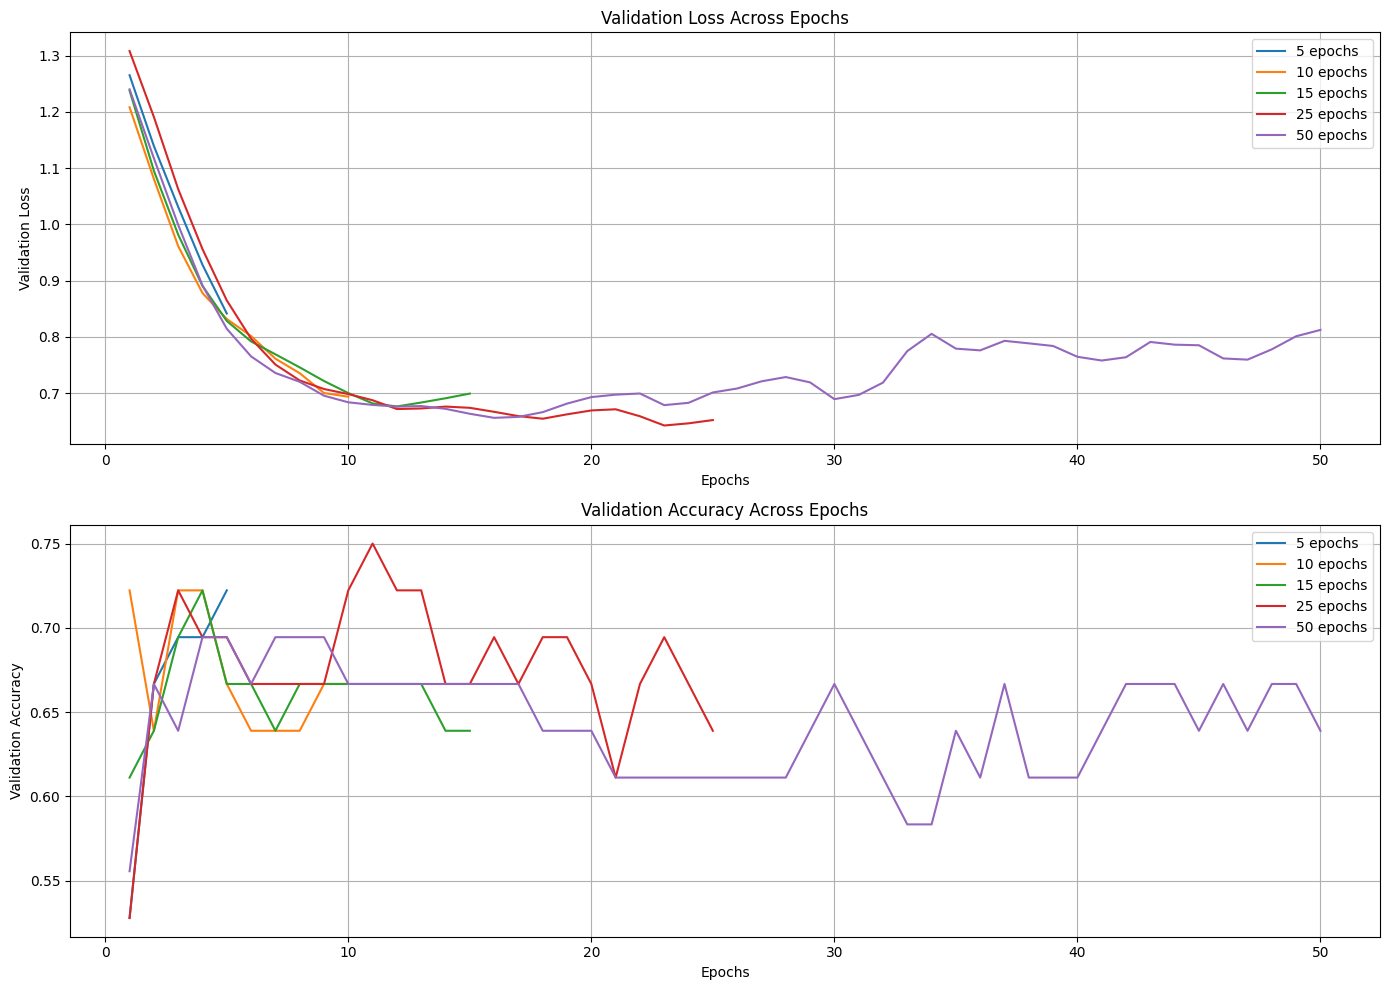

In [28]:
# Plot validation loss and accuracy for different epoch values
plt.figure(figsize=(14, 10))

# Validation Loss Plot
plt.subplot(2, 1, 1)
for result in epoch_results:
    plt.plot(range(1, len(result["val_loss_history"]) + 1), result["val_loss_history"], label=f'{result["epochs"]} epochs')
plt.title("Validation Loss Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid()

# Validation Accuracy Plot
plt.subplot(2, 1, 2)
for result in epoch_results:
    plt.plot(range(1, len(result["val_accuracy_history"]) + 1), result["val_accuracy_history"], label=f'{result["epochs"]} epochs')
plt.title("Validation Accuracy Across Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Step: Retraining the Model with Optimal Epochs

Based on our analysis of validation loss and accuracy, we identified the **optimal number of epochs** to be around **12** (or another determined value based on the plots).

### Why Retrain?
1. **Focused Training**: By training the model for the exact number of optimal epochs, we ensure that the model learns effectively without overfitting.
2. **Best Performance**: Retraining allows us to use the entire training dataset (no validation split) for a final, refined model.

### Next Steps:
- Retrain the model using the optimal number of epochs.
- Evaluate its performance on the **test set** to confirm the improvements.
- Display the final results for test accuracy and loss.


In [32]:
# Retrain the model with the optimal number of epochs
print(f"\nRetraining the model with the optimal {optimal_epochs} epochs...")

final_model = build_best_model(input_dim=X_train.shape[1])
final_history = final_model.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the final model on test data
final_loss, final_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Model Test Loss: {final_loss:.4f}")
print(f"Final Model Test Accuracy: {final_accuracy:.4f}")



Retraining the model with the optimal 23 epochs...
Epoch 1/23


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2581 - loss: 1.4389 - val_accuracy: 0.6944 - val_loss: 1.2097
Epoch 2/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3673 - loss: 1.3181 - val_accuracy: 0.7222 - val_loss: 1.1075
Epoch 3/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4835 - loss: 1.2101 - val_accuracy: 0.6944 - val_loss: 1.0094
Epoch 4/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5385 - loss: 1.1163 - val_accuracy: 0.6944 - val_loss: 0.9167
Epoch 5/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5286 - loss: 1.0980 - val_accuracy: 0.6944 - val_loss: 0.8512
Epoch 6/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4955 - loss: 1.0722 - val_accuracy: 0.7222 - val_loss: 0.8068
Epoch 7/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5521 - loss: 1.0150 - val_accuracy: 0.6667 - val_loss: 0.7734
Epoch 8/23
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6343 - loss: 0.8944 - val_accuracy: 0.5833 - val_loss: 0.7461
Epoch 9/23


## Conclusion

The model achieved an accuracy of **68%**, which indicates that it is learning meaningful patterns and performing better than random guessing. However, this result is **not optimal**, as there is still significant room for improvement.

### Key Observations:
1. **Suboptimal Generalization**:
   - An accuracy of 68% suggests that the model is still making significant errors on test cases, which may limit its practical application.
   
2. **Feature and Model Complexity**:
   - Given the effort spent on building a deep neural network, this result highlights the need for further improvements in either the model's architecture or the dataset quality.


### Final Note:
While the accuracy of 68% is a step in the right direction, it highlights the importance of continued experimentation and refinement to achieve a model that is robust and ready for practical use.
